# Bayesian Hyperparameter Optimization using Gaussian Processes

TODO: animation of GP optimization

TODO: intro

TODO: outline

First, let's import the packages we'll use, and set some settings.

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['image.cmap'] = 'viridis'

We'll also be using [CatBoost](https://catboost.ai/) for prediction, so let's install and import that as well.

In [3]:
!pip install -q catboost

    100% |████████████████████████████████| 60.1MB 545kB/s 


In [0]:
from catboost import CatBoostRegressor

A more complete version of the code we'll be working with here is available [on GitHub](http://github.com/brendanhasz/dsutils).  We'll also import the two relevant components from that repository which this post shows how to build:

In [5]:
!pip install git+http://github.com/brendanhasz/dsutils.git
from dsutils.optimization import GaussianProcessOptimizer
from dsutils.optimization import optimize_params

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-4ktk2eyd
  Stored in directory: /tmp/pip-ephem-wheel-cache-y_8w1syc/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils


## The Math

TODO: gaussian process, expensive function, etc

To determine what point to sample next, we can find the hyperparameters which maximize an "acquisition function".  The acquisition function is a function that when evaluated at $\mathbf{x}$ (some combination of hyperparameters), tells us how advantagous it would be to evaluate our expensive function $f$ at that point.  That way, we can use the acquisition function to find the next combination of hyperparameters we should try!

There are a few different functions which we could use for the acquisition function, including the probability of improvement, the expected improvement, and the upper confidence bound. Here we'll use the expected improvement as our acquisition function.

The expected improvement for some combination of hyperparameters $\mathbf{x}$ is, like the name suggests, the average improvement that we expect from that combination of hyperparameters over the best set we've found so far ($\hat{\mathbf{x}}$):

$$
EI(\mathbf{x}) = \mathbb{E}[\max (0, ~ f(\mathbf{x})-f(\hat{\mathbf{x}})) ]
$$

where $f(\mathbf{x})$ is our Gaussian process' estimation as to our model's performance with hyperparameter combination $\mathbf{x}$, and $f(\hat{\mathbf{x}})$ is the best performance that we've actually acheived so far.

How do we actually compute that?  The Gaussian process is modeling the probability of our model's performance ($f$) as a function of the hyperparameters ($\mathbf{x}$), and so at any value of $\mathbf{x}$, it gives us a normal distribution for its prediction of the value of $f$:

$$
p(f(\mathbf{x})|\mathbf{x}) ~ \sim ~ \mathcal{N}(\mu(\mathbf{x}), \sigma(\mathbf{x}))
$$

So, we can integrate that probability distribution (times the improvement magnitude) above the value of our current best performance value.   

TODO: diagram

This gives us how much of an improvement we can expect with hyperparameters $\mathbf{x}$ over our current best, $\hat{\mathbf{x}}$.

$$
\begin{align}
EI(\mathbf{x}) &= \int_{f(\hat{\mathbf{x}})}^\infty p(f(\mathbf{x})|\mathbf{x}) (f(\mathbf{x})-f(\hat{\mathbf{x}}))  df(\mathbf{x}) \\
&= \int_{f(\hat{\mathbf{x}})}^\infty\mathcal{N}(f(\mathbf{x})|\mu(\mathbf{x}), \sigma(\mathbf{x})) ~ (f(\mathbf{x})-f(\hat{\mathbf{x}}))  ~ df(\mathbf{x}) \\
\end{align}
$$


After "applying some tedious integration by parts" ([Jones et al., 1998](https://link.springer.com/article/10.1023/A:1008306431147)),  we have an analytical solution:

$$
EI(\mathbf{x}) = (\mu(\mathbf{x})-f(\hat{\mathbf{x}}))\Phi(z) + \sigma(\mathbf{x}) \phi(z)
$$

where $\Phi$ is the cumulative distribution function of the standard normal distribution, $\phi$ is the probability density function of the standard normal, and $z$ is the scaled difference between the Gaussian process mean and our current best performance:

$$
z = \frac{\mu(\mathbf{x})-f(\hat{\mathbf{x}})}{\sigma(\mathbf{x})}
$$

Using our Gaussian process to estimate $\mu(\mathbf{x})$ and $\sigma(\mathbf{x})$, we can then search for the $\mathbf{x}$ which we expect to give us the best expected improvement if we take our next sample there:

$$
\mathbf{x}_{t+1} = \arg \max_{\mathbf{x}_{t+1}} EI(\mathbf{x}_{t+1})
$$


For more information, 
[Brochu et al., 2010](https://arxiv.org/abs/1012.2599) is a great tutorial on Bayesian optimization, which includes an intro to Gaussian processes and info about several different types of acquisition functions.  But enough math - on to the code!

## Bayesian Optimization

Bayesian optimization isn't specific to finding hyperparameters - it lets you optimize *any* expensive function.  That includes, say, the parameters of a simulation which takes a long time, or the configuration of a scientific research study, or the appearance of a website during an A/B test.  Before we write code to optimize our hyperparameters, we'll build a system which can optimize any expensive function using Bayesian optimization.


### The code

To optimize our expensive function, let's build a python class which we can use to keep track of the hyperparameter combinations we've sampled, the resulting error, and then suggest the next combination of hyperparameters that we should try based on that information.

When initializing the optimizer, the user should define the lower and upper bounds of the parameters to optimize (so our optimizer can search some confined space!).  Also, the user should be able to specify whether they want to maximize or minimize the function (we'll do that via a `minimize` arg).

For example, to create an optimizer which finds the maximum of a function with 2 parameters, the first a float between 0 and 1, and the second an integer between 10 and 100, the user should be able to do:

In [0]:
gpo = GaussianProcessOptimizer([0, 10], [1, 100],
                               minimize=False)

So to start, let's build the class definition and the constructor (which defines how one initializes the object, as above):

In [0]:
class GaussianProcessOptimizer():
    """Bayesian function optimizer which uses a Gaussian process to model the
    expensive function, and expected improvement as the acquisition function.
    """

    def __init__(self, lb, ub, minimize=True):
        """Gaussian process-based optimizer

        Parameters
        ----------
        lb : list
            Lower bound for each parameter.
        ub : list
            Upper bound for each parameter.
        minimize : bool
            Whether to minimize (True) or maximize (False).
        """

        # Store parameters
        self.lb = lb
        self.ub = ub
        self.minimize = minimize
        self.db = [ub[i]-lb[i] for i in range(self.num_dims)]
        self.bounds = [(lb[i], ub[i]) for i in range(self.num_dims)]

        # Gaussian process to use for estimating the function
        self.gp = GaussianProcessRegressor(
            kernel=RationalQuadratic()+WhiteKernel(noise_level=1e-3), 
            alpha=0.0,
            n_restarts_optimizer=10,
        )

        # Keep track of points so far, and the best
        self.x = []
        self.y = []
        self.opt_x = None
        if minimize:
            self.opt_y = np.inf
        else:
            self.opt_y = -np.inf

The class will also need a function to add points to the history, and the resulting function value corresponding to that point.  This function should allow multiple y values per x value, because when we use it for estimating the cross-validated scores, we'll have a different score for each fold!  Also, the function should keep track of the point corresponding to the best y value which has been sampled so far.  We'll add this function to the `GaussianProcessOptimizer` class:

In [0]:
def add_point(self, x, y):
    """Add a point to the history of sampled points."""

    # Append to sample record
    if isinstance(y, list): #repeated x values
        for ty in y:
            self.x.append(x)
            self.y.append(ty)
        ty = np.array(y).mean()
    else:
        self.x.append(x)
        self.y.append(y)
        ty = y

    # Store best point so far
    if self.minimize:
        if ty < self.opt_y:
            self.opt_y = ty
            self.opt_x = x
    else:
        if ty > self.opt_y:
            self.opt_y = ty
            self.opt_x = x

The meat of the optimizer is its ability to fit a Gaussian process to the sampled points, so we'll add a private function to do that fitting.  We'll normalize the y-values, which will cause our Gaussian process to assume that, in areas of parameter space which we have not explored yet, the y-values are roughly equal to the mean of the y-values for the points which we have sampled.  The way in which we normalize y will need to be kept track of, so that we can *un*-normalize the predictions of the Gaussian process.

We'll also normalize the x-values so that we have to worry less about the exact value of the length-scale parameter of the Gaussian process (see my [previous post](https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html) on Gaussian processes to see why that can be a pain).  Let's add to the `GaussianProcessOptimizer` class a method to fit the Gaussian process:

In [0]:
def _fit_gp(self, step=None):
    """Fit the Gaussian process to data."""

    # Normalize y
    self._y_mean = y.mean()
    self._y_std = y.std()
    y = (y-self._y_mean)/self._y_std

    # Normalize x
    for iD in range(self.num_dims):
        x[:, iD] = (x[:, iD]-self.lb[iD]) / self.db[iD]

    # Fit the Gaussian process
    self.gp = self.gp.fit(x, y)

Our optimizer will also need to be able use the Gaussian process to predict the y-values (e.g. the cross-validated performance) for a given x-value (e.g. the hyperparameter values).  We need to normalize the new x values in the same way we did when fitting the Gaussian process (above), and un-normalize the predicted y-values as discussed above.  Let's another private method to the class which performs that prediction:

In [0]:
def _pred_gp(self, x, return_std=False):
    """Predict y with the Gaussian process."""

    # Normalize x
    for iD in range(self.num_dims):
        x[:, iD] = (x[:, iD] - self.lb[iD]) / self.db[iD]

    # Predict y
    y, y_std = self.gp.predict(x, return_std=True)

    # Convert y back to true scale
    y = y*self._y_std+self._y_mean
    y_std = y_std*self._y_std

    # Return std dev if requested
    if return_std:
        return y, y_std
    else:
        return y

The last key peice of the optimizer is the acquisition function.  Let's add one last private method to the `GaussianProcessOptimizer` class which uses the Gaussian process' estimate and uncertainty as to the y-values to compute the expected improvement:

In [0]:
def _expected_improvement(self, x):
    """Compute the expected improvement at x."""

    # Predict performance at x
    mu, sigma = self._pred_gp(x.reshape(-1, self.num_dims),
                              return_std=True)

    # Compute and return expected improvement
    flip = np.power(-1, self.minimize)
    z = flip*(mu-self.opt_y)/sigma
    return flip*(mu-self.opt_y)*norm.cdf(z) + sigma*norm.pdf(z)

Now that our optimizer is able to fit the Gaussian process to our data, we need it to be able to suggest points to sample.  The easiest method of suggesting points is just generating a random point that's within the parameter bounds:

In [0]:
def random_point(self, get_dict=False):
    """Get a random point within the bounds."""
    return np.random.uniform(self.lb, self.ub)

But what we really want is for the optimizer to suggest a point which is either likely to have a good y-value, or a point for which we're highly uncertain as to the y-values in that area of parameter space.  We'll add to the `GaussianProcessOptimizer` class a method which first fits a Gaussian process to the points sampled so far, uses that fit Gaussian process to compute the expected improvement, and then searches for the x-values which result in the best expected improvement:

In [0]:
def next_point(self):
    """Get the point with the highest expected improvement."""

    # Fit the Gaussian process to samples so far
    self._fit_gp()

    # Find x with greatest expected improvement
    x = self.random_point()
    best_score = np.inf
    n_restarts = 10
    for iR in range(n_restarts):

        # Maximize expected improvement
        res = minimize(lambda x: -self._expected_improvement(x),
                       self.random_point(),
                       method='L-BFGS-B',
                       bounds=self.bounds)

        # Keep x if it's the best so far
        if res.fun < best_score:
            best_score = res.fun
            x = res.x

    # Return x with highest expected improvement
    return x

After sampling as many points as we have time to sample, we'll want the optimizer to spit out the point which results in the best y-value.  There's two ways we could do this.  The simplest way would be for the optimizer to simply search the history of sampled points to find the point with the highest y-value.  However, a different method would be to use the Gaussian process to find the point with the best *predicted* y-value.  We'll add to the `GaussianProcessOptimizer` class a function which takes a `expected` argument that allows the user to choose between the two options.  When `expected=True` (the default), the opimizer will search for the point which has the best y-value, as predicted by the Gaussian process.  When `expected=False`, the optimizer object will simply return the point in the sample history which had the highest y-value.

In [0]:
def best_point(self, expected=True):
    """Get the best point (expected or actual)"""

    # Return best point which was actually sampled
    if not expected:
        return self.x[self.y.index(min(self.y))]

    # Fit the Gaussian process to samples so far
    self._fit_gp()

    # Find x with greatest expected score
    flip = np.power(-1, self.minimize)
    rx = x.reshape(-1,self.num_dims)
    score_func = lambda x: flip*self._pred_gp(rx)
    x = self.random_point()
    best_score = np.inf
    n_restarts = 10
    for iR in range(n_restarts):

        # Maximize expected improvement
        res = minimize(score_func, 
                       self.random_point(),
                       method='L-BFGS-B',
                       bounds=self.bounds)

        # Keep x if it's the best so far
        if res.fun < best_score:
            best_score = res.fun
            x = res.x

    # Return x with highest expected value
    return x

Finally, we want a way to visualize the Gaussian process' estimate of the expensive function's value.  We'll add to the optimizer class a method which plots the sampled points along with the Gaussian process' estimate of the function value in either one or two dimensions:

In [0]:
def plot_surface(self, x_dim=0, y_dim=None, res=100):
    """Plot the estimated surface of the function"""

    # Fit the Gaussian process to points so far
    self._fit_gp()

    # 1D plot
    if y_dim is None:

        # Predict y as a fn of x
        res = 100 #resolution
        x_pred = np.ones((res, self.num_dims))
        x_pred *= (np.array(self.bounds)
                   .mean(axis=1)
                   .reshape(-1, self.num_dims))
        x_pred[:,x_dim] = np.linspace(self.lb[x_dim], 
                                      self.ub[x_dim], res)
        y_pred, y_err = self._pred_gp(x_pred, return_std=True)

        # Plot the Gaussian process' estimate of the function
        plot_err(x_pred[:, x_dim], y_pred, y_err)

        # Plot the sampled points
        for iP in range(len(self.x)):
            plt.plot(self.x[iP][x_dim], 
                     self.y[iP], '.', color='0.6')

    # 2D plot
    else:

        # Predict y as a fn of x
        res = 100 #resolution
        x_pred = np.ones((res*res, self.num_dims))
        x_pred *= (np.array(self.bounds)
                   .mean(axis=1)
                   .reshape(-1, self.num_dims))
        xp, yp = np.meshgrid(
            np.linspace(self.lb[x_dim], self.ub[x_dim], res),
            np.linspace(self.lb[y_dim], self.ub[y_dim], res))
        x_pred[:,x_dim] = xp.reshape(-1)
        x_pred[:,y_dim] = yp.reshape(-1)
        y_pred = self._pred_gp(x_pred, return_std=False)

        # Plot the Gaussian process
        plt.imshow(y_pred.reshape((res, res)), aspect='auto', 
                   interpolation='bicubic', origin='lower',
                   extent=(self.lb[x_dim], self.ub[x_dim], 
                           self.lb[y_dim], self.ub[y_dim]))
        plt.colorbar()

        # Plot the sampled points
        for iP in range(len(self.x)):
            plt.plot(self.x[iP][x_dim], 
                     self.x[iP][y_dim], 
                     '.', color='0.6')

### Minimizing a 1D Function

Now we can find the minimum (or maximum) of any expensive function with our Bayesian optimizer.  Supose we have some expensive function (the function below isn't expensive, of course, but is just for demonstration purposes):

In [0]:
# Some 1D function
func = lambda x: -np.sin(x)/x + 0.1*np.random.randn()

We can use the optimizer class we just created to find the minimum of that function in as few steps as possible.  The optimizer lets us sample random points in the range:

In [0]:
# Create an optimizer object
# (using the class we just created!)
gpo = GaussianProcessOptimizer([-10], [10])

# Randomly sample points
for i in range(10):
  
    # Get a new random point in the range
    new_params = gpo.random_point()
    
    # Compute the function value at that point
    # (this is usually the expensive part)
    value = func(new_params)
    
    # Store the outcome
    gpo.add_point(new_params, value)
    
    # Plot the function estimate
    gpo.plot_surface()

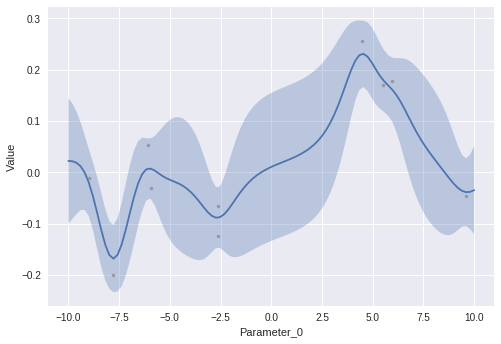

In [38]:
#gpo.plot_surface()
# TODO: animation using step arg

But more importantly, it provides suggestions as to where to sample next, in order to most effectively minimize the function:

In [39]:
# Find the minimum w/ as few steps as possible
for i in range(10):
  
    # Get a new random point in the range
    new_params = gpo.next_point()
    
    # Compute the function value at that point
    # (this is usually the expensive part)
    value = func(new_params)
    
    # Store the outcome
    gpo.add_point(new_params, value)
    
    # Plot the function estimate
    gpo.plot_surface()

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.50286965e-05,  1.68961200e-04, -1.21799232e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 32, 'warnflag': 2}
  ConvergenceWarning)


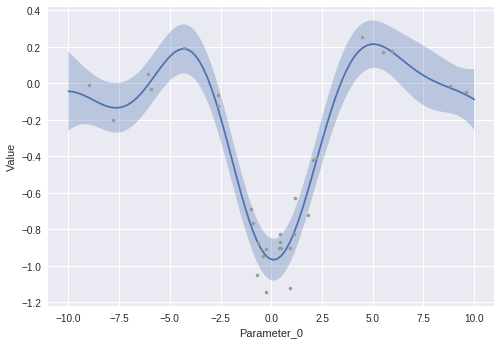

In [40]:
#gpo.plot_surface()
# TODO: animation using step arg

Notice how when sampling the points the optimizer suggests, the samples concentrate around the minimum of the function, allowing us to better-explore promising areas of parameter space.

### Minimizing a 2D Function

Our optimizer would only be moderately useful if it could only optimize one parameter at a time!  Luckily Gaussian processes can handle multiple dimensions, and therefore so can our optimizer.  For example, suppose we have an expensive-to-evaluate two-dimensional function (again, this isn't expensive but just for demonstration purposes):

In [0]:
# Some 2D function
func = lambda x: (-np.sin(x[0])/x[0] 
                  - np.sin(x[1])/x[1] 
                  + 0.1*np.random.randn())

We can create a 2D optimizer and make some random samples in exactly the same way as before:

In [0]:
# Create an optimizer object
gpo = GaussianProcessOptimizer([-10, -10], [10, 10], dtype=[float, float])

# Perform a few random samples
for i in range(40):
  
    # Get a new random point in the range
    new_params = gpo.random_point()
    
    # Compute the function value at that point
    value = func(new_params)
    
    # Store the outcome
    gpo.add_point(new_params, value)
    
    # Plot the surface
    #gpo.plot_surface(x_dim=0, y_dim=1)

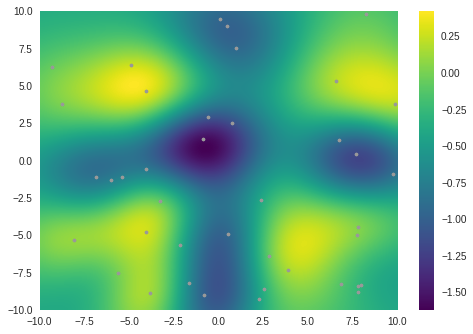

In [56]:
gpo.plot_surface(x_dim=0, y_dim=1)
plt.grid(False)
plt.show()

And we can also make directed samples in the same way as before:

In [0]:
# Sample directed by the optimizer
for i in range(10):
  
    # Point suggested by optimizer
    new_params = gpo.next_point()
    
    # Compute the function value at that point
    value = func(new_params)
    
    # Store the outcome
    gpo.add_point(new_params, value)
    
    # Plot the surface
    #gpo.plot_surface(x_dim=0, y_dim=1)

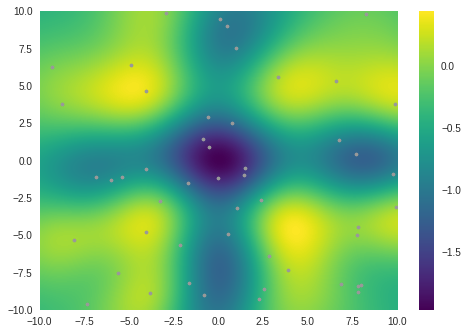

In [58]:
gpo.plot_surface(x_dim=0, y_dim=1)
plt.grid(False)
plt.show()

Notice how the optimizer now focuses on promising areas, occasionally exploring the more unexplored areas of parameter-space.  Also keep in mind that the `GaussianProcessOptimizer` isn't limited to just 1 or 2 dimensions - in theory it can handle as many dimensions as you can throw at it.  But of course the curse of dimensionality will catch up with you fairly quickly and you'll need an inordinate number of samples to perform effective optimization.

## Hyperparameter Optimization

Now that we have a Bayesian optimizer, we can create a function to find the hyperparameters of a machine learning model which optimize the cross-validated performance.  All this function needs is the x and y data, the predictive model (in the form of an sklearn Estimator), and the hyperparameter bounds.  The user should also be able to specify what metric to optimize (e.g. mean squared error or accuracy), in addition to whether that metric should be maximized or minimized.  This is because some metrics are better when lower, like mean squared error, while others are better when higher, like the coefficient of determination.  Users should also be able to specify how many samples to be taken, and how many random samples to take before switching to Bayesian optimization.  This function won't be a method of `GaussianProcessOptimizer`, but rather a stand-alone function which uses that class.

In [0]:
def optimize_params(X, y, model, bounds,
                    metric=make_scorer(mean_squared_error),
                    minimize=True,
                    n_splits=3,
                    shuffle=True,
                    max_evals=50,
                    n_random=5):
    """Optimize model parameters using cross-fold validation.

    Parameters
    ----------
    X : pandas DataFrame
        Independent variable values (features)
    y : pandas Series
        Dependent variable values (target)
    model : sklearn Estimator
        Predictive model to optimize
    bounds : dict
        Parameter bounds.
    metric : sklearn scorer
        Metric to use for evaluation.
    minimize : bool
        Whether to minimize ``metric``.  
        If true, minimize; if false, maximize.
    n_splits : int
        Number of cross-validation folds.
    shuffle : bool
        Whether to shuffle samples before splitting into CV folds.
    max_evals : int
        Max number of cross-validation evaluations to perform.
    n_random : int
        Number of evaluations to use random parameter combinations
        before switching to Bayesian global optimization.

    Returns
    -------
    opt_params : dict
        Optimal parameters.
    optimizer : dsutils.optimization.GaussianProcessOptimizer
        Optimizer used to select the points.  Contains the history
        of all points which were sampled.
    """

    # Collect info about parameters to optimize
    Np = len(bounds) #number of parameters
    step_params = [e for e in bounds]
    steps = [e.split('__')[0] for e in step_params]
    params = [e.split('__')[1] for e in step_params]
    lb = [bounds[e][0] for e in step_params]
    ub = [bounds[e][1] for e in step_params]

    # Initialize the Gaussian process optimizer
    gpo = GaussianProcessOptimizer(lb, ub, minimize=minimize)

    # Create a cross-fold generator
    kf = KFold(n_splits=n_splits, shuffle=shuffle)

    # Search for optimal parameters
    for i in range(max_evals):

        # Get next set of parameters to try
        if i < n_random:
            new_params = gpo.random_point()
        else:
            new_params = gpo.next_point()

        # Modify model to use new parameters
        for iP in range(Np):
            tP = {params[iP]: new_params[iP]}
            model.named_steps[steps[iP]].set_params(**tP)

        # Compute and store cross-validated metric
        scores = cross_val_score(model, X, y, cv=kf,
                                 scoring=scorer, n_jobs=n_jobs)

        # Store parameters and scores
        gpo.add_point(new_params, scores)

    # Return optimal parameters and the optimizer object used
    opt_params = dict(zip(step_params, gpo.best_point()))
    return opt_params, gpo

### Optimizing One Hyperparameter

Let's try the hyperparameter optimizer out on some real data.

TODO: test on some real data, optimize a hyperparam in 1D, plot score vs hyperparam value

In [0]:
# Load the diabetes dataset
# TODO: well, maybe could use one that's a bit bigger...
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X_data = pd.DataFrame(diabetes['data'])
y_data = pd.Series(diabetes['target'], X_data.index)
y_data = (y_data-y_data.mean())/y_data.std()

In [0]:
# CatBoost pipeline
catboost = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', CatBoostRegressor(verbose=False, 
                                    loss_function='RMSE', 
                                    learning_rate=0.1))
])

# Parameter bounds
bounds = {
    'regressor__learning_rate': [0.01, 0.5, float],
}

# Find the optimal parameters
opt_params, gpo = optimize_params(
    X_data, y_data, catboost, bounds,
    n_splits=3, shuffle=False,
    max_evals=2, n_random=2)

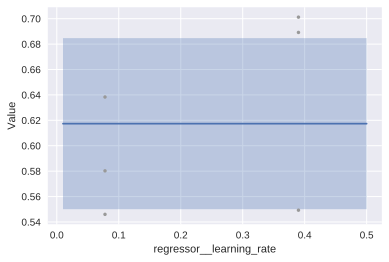

In [13]:
gpo.plot_surface()

### Optimizing Multiple Hyperparameters

TODO: test on some real data, optimize the hyperparams in 2D, plot animation for 2D case

In [0]:
# CatBoost pipeline
catboost = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', CatBoostRegressor(verbose=False, 
                                    loss_function='RMSE', 
                                    learning_rate=0.1,
                                    l2_leaf_reg=2.0))
])

# Parameter bounds
bounds = {
    'regressor__learning_rate': [0.01, 0.5, float],
}

## Conclusion

TODO: Other packages for Bayesian optimization

* [HyperOpt](http://hyperopt.github.io/hyperopt)
* [skopt](https://scikit-optimize.github.io)
* [MOE](https://github.com/Yelp/MOE)
* [HyperparameterHunter](https://github.com/HunterMcGushion/hyperparameter_hunter/blob/master/README.md)
* [Spearmint](https://github.com/HIPS/Spearmint)
* [BayesOpt](https://github.com/rmcantin/bayesopt)
* [SMAC](https://automl.github.io/SMAC3/stable)
* [HPOlib2](https://automl.github.io/HPOlib2/stable)

TODO: Also mention that tree parzen estimators have been used instead of gaussian processes